# 📺 View channels

In [ ]:
#| default_exp repr_chans

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test_eq
from lovely_numpy import lo


In [ ]:
# |hide
# |export
from typing import Any, Optional as O

import numpy as np
from matplotlib import axes, figure, pyplot as plt
from IPython.core.pylabtools import print_figure

from lovely_numpy.repr_rgb import fig_rgb, rgb
from lovely_numpy.utils.colormap import InfCmap, get_cmap
from lovely_numpy.utils.config import config, get_config
from lovely_numpy.utils.utils import cached_property

In [ ]:
# |exporti

def fig_chans(  x           :np.ndarray,      # Input array
                cmap        :str="twilight",  # Use matplotlib colormap by this name
                cm_below    :str="blue",
                cm_above    :str="red",
                cm_ninf     :str="cyan",
                cm_pinf     :str="fuchsia",
                cm_nan      :str="yellow",
                gutter_px   :int=3,         # Draw write gutters when tiling the images
                frame_px    :int=1,         # Draw black frame around each image
                scale       :int=1,         # Stretch the image. Only itegers please.
                cl          :Any=True,
                view_width  :int=966,
                ax          :O[axes.Axes]=None
        ) -> figure.Figure:
    """
    Process individual channels of a ndarray that can be interpreted as as image
    """
    
    assert x.ndim >= 2, f"Expected a 2+ dim input, got {x.shape}={x.ndim}"
    if x.ndim == 2: x = x[None]
    
    if cl: # Convert to [..., C, H, W].
        x = np.swapaxes(np.swapaxes(x, -2, -1), -3, -2)

    ### XXX Do we want a way to pass a custom cmap instead of mpl one?
    inf_cmap = InfCmap(cmap=get_cmap(cmap),
                  below=cm_below, above=cm_above,
                  nan=cm_nan, ninf=cm_ninf, pinf=cm_pinf)

    return fig_rgb(inf_cmap(x), cl=True, gutter_px=gutter_px, frame_px=frame_px, scale=scale, view_width=view_width, ax=ax)


In [ ]:
# |exporti

class ChanProxy():   
    def __init__(self, x: np.ndarray):
        self.x = x
        self.params = dict( cmap        ="twilight", 
                            cm_below    ="blue",
                            cm_above    ="red",
                            cm_ninf     ="cyan",
                            cm_pinf     ="fuchsia",
                            cm_nan      ="yellow",
                            view_width  =966,
                            gutter_px   =3,
                            frame_px    =1,
                            scale       =1,
                            cl          =True,
                            ax          =None)

    def __call__(self,
                 cmap       :O[str] =None, 
                 cm_below   :O[str] =None,
                 cm_above   :O[str] =None,
                 cm_ninf    :O[str] =None,
                 cm_pinf    :O[str] =None,
                 cm_nan     :O[str] =None,
                 view_width :O[int] =None,
                 gutter_px  :O[int] =None,
                 frame_px   :O[int] =None,
                 scale      :O[int] =None,
                 cl         :Any    =None,
                 ax         :O[axes.Axes]=None):
        
        self.params.update( {   k:v for
                                k,v in locals().items()
                                if k != "self" and v is not None } )
        _ = self.fig # Trigger figure generation
        return self

    @cached_property
    def fig(self) -> figure.Figure:
        return fig_chans(self.x, **self.params)

    def _repr_png_(self):
        return print_figure(self.fig, fmt="png", pad_inches=0,
            metadata={"Software": "Matplotlib, https://matplotlib.org/"})


In [ ]:
# |export

def chans(  x           :np.ndarray,      # Input array
            cmap        :str="twilight",  # Use matplotlib colormap by this name
            cm_below    :str="blue",
            cm_above    :str="red",
            cm_ninf     :str="cyan",
            cm_pinf     :str="fuchsia",
            cm_nan      :str="yellow",
            gutter_px   :int=3,         # Draw write gutters when tiling the images
            frame_px    :int=1,         # Draw black frame around each image
            scale       :int=1,         # Stretch the image. Only itegers please.
            cl          :Any=True,
            view_width  :int=966,
            ax          :O[axes.Axes]=None
        ) -> ChanProxy:
    "Map x values to colors. RGB[A] color is added as channel-last"
    args = locals()
    del args["x"]

    return ChanProxy(x)(**args)

array[196, 196, 3] n=115248 x∈[0., 1.000] μ=0.361 σ=0.248


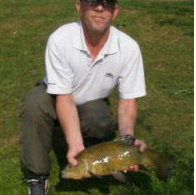

In [ ]:
in_stats = ( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )

image = np.load("mysteryman.npy").transpose(1,2,0)
image = ((image * np.array(in_stats[1])) + np.array(in_stats[0])).clip(0, 1)

print(lo(image))
rgb(image)

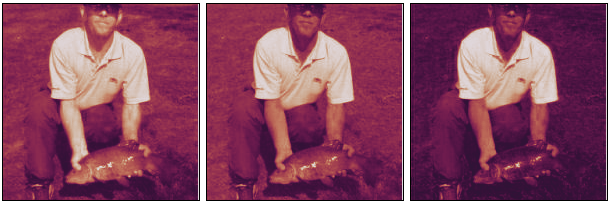

In [ ]:
chans(image)

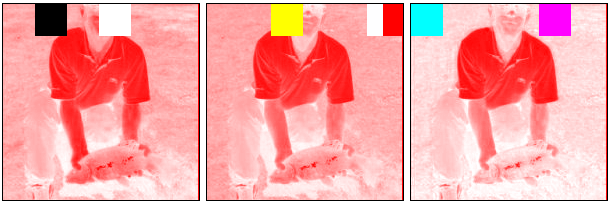

In [ ]:
# In R
image[0:32, 32:64,  0] = -1.1 # Below min
image[0:32, 96:128, 0] = 1.1 # Above max
# In G
image[0:32, 64:96,  1] = float("nan")

# In B
image[0:32, 0:32,   2] = float("-inf")
image[0:32, 128:160,2] = float("+inf")

image[0:32, 160:176,1] = 0.
image[0:32, 176:   ,1] = 1.

chans(image, cmap="bwr", cm_below="black", cm_above="white")

In [ ]:
lo(np.stack([image]*4))

array[4, 196, 196, 3] n=460992 x∈[-1.100, 1.100] μ=0.360 σ=0.298 +Inf! -Inf! NaN!

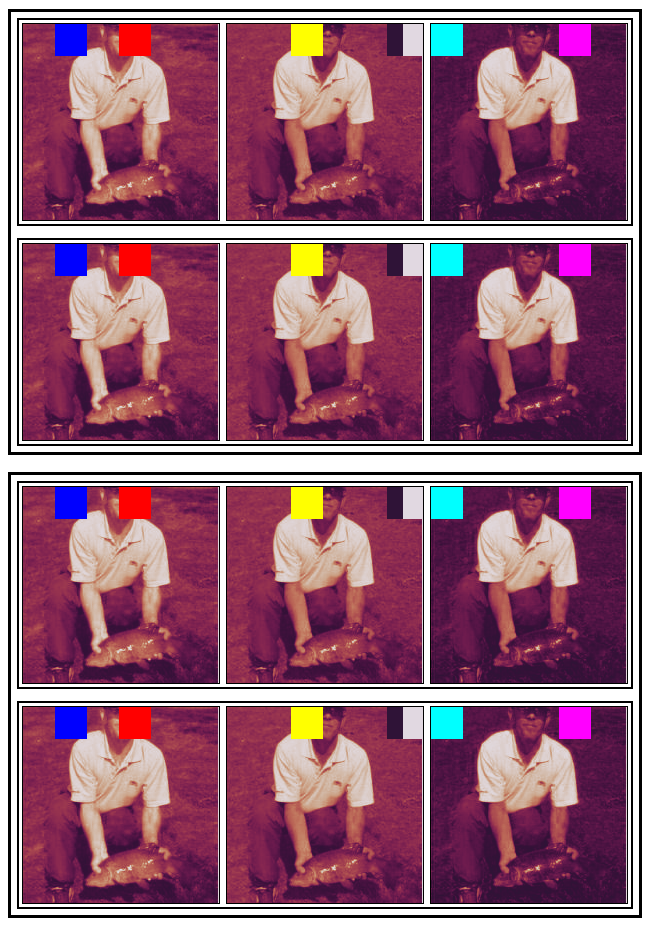

In [ ]:
# 4 images, stacked 2x2
chans(np.stack([image]*4).reshape((2,2,196,196,3)))

In [ ]:
try:
    chans(np.array([]).reshape(0,0,0))
except AssertionError as e:
    test_eq(e.args[0], "Expecting non-empty input, got shape=((0, 0, 0, 3))")
else:
    raise AssertionError("Expected AssertionError, but got nothing")

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()